Name : Ilham Muhamad Firdaus    
Student ID : 1103202001

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
training_file = "/content/drive/MyDrive/Dataset/train.p"
testing_file = "/content/drive/MyDrive/Dataset/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

print("Data loaded")

Data loaded


In [4]:
# Load CSV file
sign_name_df = pd.read_csv('/content/drive/MyDrive/Dataset/signname.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [5]:
# Displaying Data
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
# Define features and labels for training data
X, y = train['features'], train['labels']

# Converting lists into numpy arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

# Define the features and labels for testing data
X_test, y_test = test['features'], test['labels']

# Converting lists into numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


In [7]:
X, y = train['features'], train['labels']
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

(34799, 32, 32, 3) (34799,)


In [8]:
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(12630, 32, 32, 3) (12630,)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


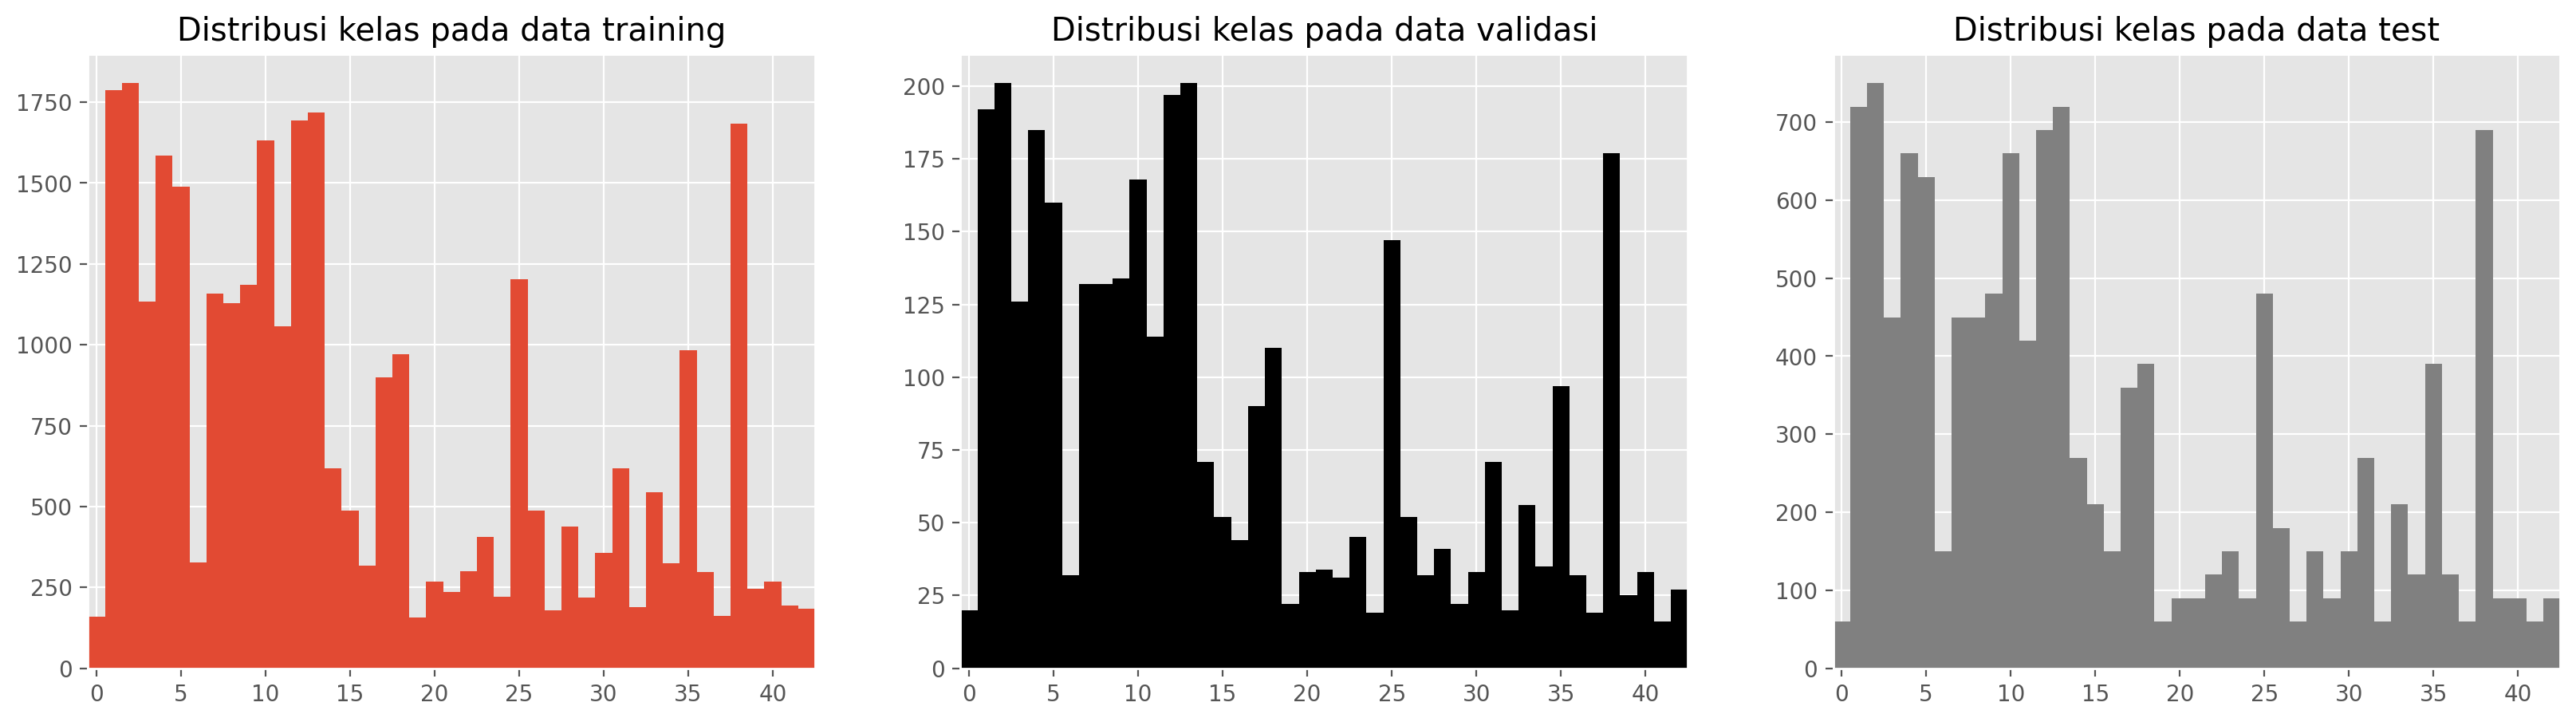

In [10]:
n_labels = np.unique(y_train).size

def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs:
        ax.legend()
    if title:
        ax.set_title(title)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

In [11]:
# Converting Labels into One-Hot Encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical (y_train,43)
y_val = to_categorical(y_val,43)

In [12]:
# callback for Early Stopping
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.96):
            print("\nAkurasi telah mencapai >96%. Stop training!")
            self.model.stop_training = True
callbacks = myCallback()

In [13]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

In [14]:
# Print Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/25
979/979 [==============================] - 183s 185ms/step - loss: 1.9591 - accuracy: 0.5036 - val_loss: 0.6398 - val_accuracy: 0.8207
Epoch 2/25
979/979 [==============================] - 154s 157ms/step - loss: 0.8138 - accuracy: 0.7563 - val_loss: 0.3627 - val_accuracy: 0.8931
Epoch 3/25
979/979 [==============================] - 151s 154ms/step - loss: 0.6254 - accuracy: 0.8060 - val_loss: 0.2300 - val_accuracy: 0.9353
Epoch 4/25
979/979 [==============================] - 153s 156ms/step - loss: 0.5388 - accuracy: 0.8326 - val_loss: 0.1851 - val_accuracy: 0.9500
Epoch 5/25
979/979 [==============================] - 150s 154ms/step - loss: 0.4804 - accuracy: 0.8486 - val_loss: 0.1700 - val_accuracy: 0.9586
Epoch 6/25
979/979 [==============================] - 159s 162ms/step - loss: 0.4203 - accuracy: 0.8711 - val_loss: 0.1357 - val_accuracy: 0.9649
Epoch 7/25
979/979 [==============================] - 151s 155ms/step - loss: 0.4067 - accuracy: 0.8760 - val_loss: 0.1440 -

In [17]:
model.save("my_GTS_CNNmodel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


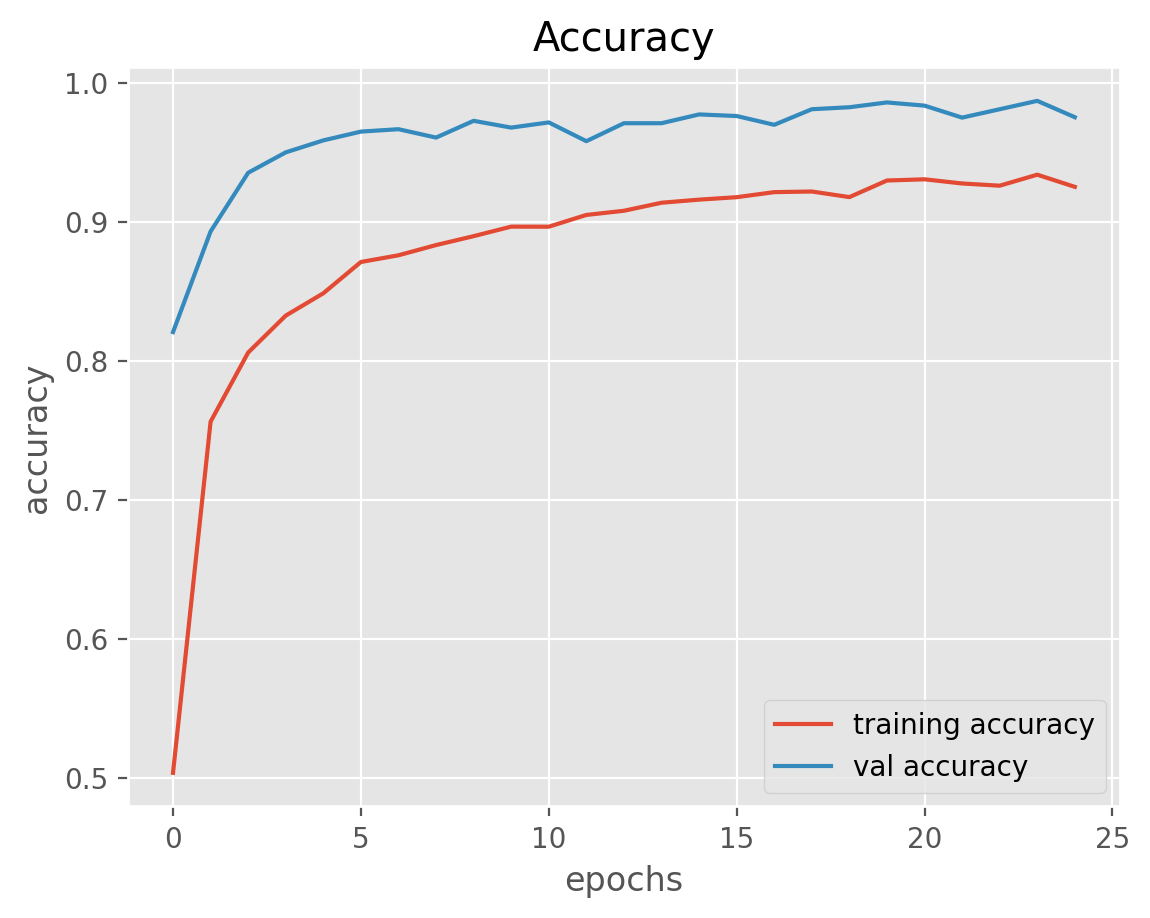

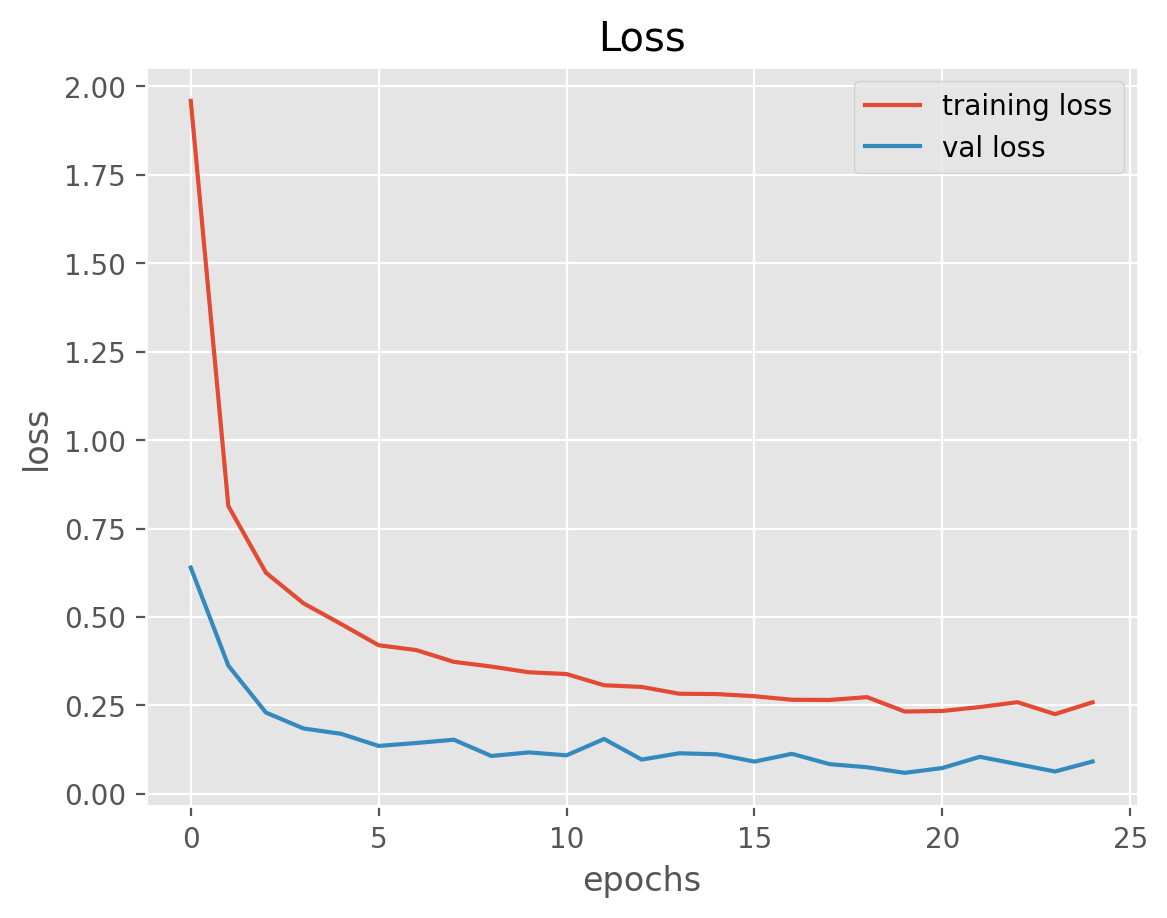

In [18]:
# Plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import accuracy_score

pred = np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

395/395 [==============================] - 16s 41ms/step


0.9317498020585907

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        60
           1       0.92      0.95      0.94       720
           2       0.98      0.91      0.94       750
           3       0.95      0.96      0.95       450
           4       0.95      0.94      0.94       660
           5       0.88      0.91      0.89       630
           6       0.97      0.77      0.86       150
           7       0.97      0.87      0.92       450
           8       0.86      0.97      0.91       450
           9       0.93      0.99      0.96       480
          10       0.94      0.99      0.96       660
          11       0.92      0.93      0.92       420
          12       0.99      0.94      0.97       690
          13       0.98      0.97      0.98       720
          14       0.99      1.00      0.99       270
          15       0.87      0.99      0.92       210
          16       0.96      0.99      0.97       150
          17       1.00    